This credit card dataset is from Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud. And this project is to detect if the incoming transaction would be fraudulent or not. 

# Set up
## Spark

In [1]:
# !pip install pyspark
# !pip install -U -q PyDrive
# !sudo apt-get install -y openjdk-8-jdk-headless -qq

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

## Import libraries

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf


## Initialize the Spark content

In [3]:
# create the context
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

24/03/27 11:45:12 WARN Utils: Your hostname, Wens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.1.50 instead (on interface en0)
24/03/27 11:45:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/27 11:45:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/27 11:45:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51054)
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/opt/homebrew/lib/python3.12/site-packages/pyspar

## Read the csv file

In [4]:
card_df = spark.read.csv('creditcard.csv', header=True, inferSchema=True)

In [5]:
# card_df.repartition(100)

## Data Normalization

In [6]:
from pyspark.sql.functions import mean

# Calculate the mean for each column
means = card_df.select([mean(col).alias(col) for col in card_df.columns])

# Convert the mean values to a dictionary
mean_dict = means.first().asDict()

# Replace null values with means
for col in card_df.columns:
    card_df = card_df.fillna(mean_dict[col], subset=[col])

24/03/27 11:45:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
# Convert 'Amount' column to a vector
assembler = VectorAssembler(inputCols=['Amount'], outputCol='amount_vector')
card_df = assembler.transform(card_df)

# Define the StandardScaler
scaler = StandardScaler(inputCol="amount_vector", outputCol="scaledAmount", withStd=True, withMean=True)

# Compute summary statistics and fit the StandardScaler
scalerModel = scaler.fit(card_df)

# Transform the data using the scaler model
card_df = scalerModel.transform(card_df)

# Define a UDF to extract the first element of the vector and cast to DoubleType
extract_double_udf = udf(lambda v: float(v[0]), DoubleType())

# Apply the UDF to create a new column with scaled amount as DoubleType
card_df = card_df.withColumn("scaledAmountDouble", extract_double_udf("scaledAmount"))


# Drop the unrelated columns - Time, Amount, scaledAmount, amount_vector
card_df = card_df.drop('Time', 'Amount', 'scaledAmount', 'amount_vector')


## Split the dataset into train and test datasets

In [8]:
train = card_df.sampleBy("Class", fractions = {0: 0.7, 1: 0.7}, seed=10)
test = card_df.subtract(train)

# Save train and test sets to CSV files
# train.toPandas().to_csv("/kaggle/working/train.csv", index=False)
# test.toPandas().to_csv("/kaggle/working/test.csv", index=False)

# train = spark.read.csv('/content/train.csv', header=True, inferSchema=True)
# test = spark.read.csv('/content/test.csv', header=True, inferSchema=True)
train.groupBy("Class").count().show()
test.groupBy("Class").count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|   339|
|    0|198786|
+-----+------+



+-----+-----+
|Class|count|
+-----+-----+
|    1|  144|
|    0|81550|
+-----+-----+



# Modeling
## Random Forest

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

def preprocess_data(data):
    # Preprocessing: StringIndexer for categorical labels
    stringIndexer = StringIndexer(inputCol="Class", outputCol="label")

    # Define the feature and label columns & Assemble the feature vector
    input_cols = [col for col in data.columns if col != "Class"]

    assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

    return stringIndexer, assembler, input_cols

def randomForest():
    # Create a RandomForestClassifier
    rf = RandomForestClassifier(labelCol="label", featuresCol="features")

    # # Create a pipeline
    # pipeline = Pipeline(stages=[stringIndexer, assembler, rf])

    # return pipeline
    return rf

def train_and_predict_with_pipeline(pipeline, train, test):
    # Fit the pipeline to the training data
    model = pipeline.fit(train)

    # Perform predictions on the test data
    prediction = model.transform(test)

    return model, prediction

def predict(prediction):
    tp = prediction.filter("Class = 1 AND prediction = 1").count()
    fp = prediction.filter("Class = 0 AND prediction = 1").count()
    tn = prediction.filter("Class = 0 AND prediction = 0").count()
    fn = prediction.filter("Class = 1 AND prediction = 0").count()
    print(fp, fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    print("Prediction summary")
    print("Accuracy: ", accuracy, "Precision: ", precision, "Recall: ", recall, "F1: ", f1)

    return f1


### Check if the model is overfitting or underfitting

In [10]:
stringIndexer, assembler, input_cols = preprocess_data(card_df)
rf = randomForest()
pipeline = Pipeline(stages=[stringIndexer, assembler, rf])

def predict_model(train, test):
  model = pipeline.fit(train)
  prediction = model.transform(test)
  f1 = predict(prediction)
  return f1

In [11]:
predict_model(train, train)

38 79
Prediction summary
Accuracy:  0.999412429378531 Precision:  0.87248322147651 Recall:  0.7669616519174042 F1:  0.8163265306122449


0.8163265306122449

In [12]:
predict_model(train, test)

12 40
Prediction summary
Accuracy:  0.999363478346023 Precision:  0.896551724137931 Recall:  0.7222222222222222 F1:  0.7999999999999999


0.7999999999999999

In [13]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def tuning(train, test):
  # Define the parameter grid
  paramGrid = ParamGridBuilder() \
      .addGrid(rf.numTrees, [10, 20, 30]) \
      .addGrid(rf.maxDepth, [5, 10, 15]) \
      .build()

  # Define the evaluator
  evaluator = MulticlassClassificationEvaluator(metricName="f1")

  # Cross-validation
  crossval = CrossValidator(estimator=pipeline,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            numFolds=5)

  # Train model
  cvModel = crossval.fit(train)

  # Make predictions
  predictions = cvModel.transform(test)

  # Evaluate model
  f1_score = predict(predictions)

  # Get best parameters
  # best_params = cvModel.bestModel.stages[-1].extractParamMap()

  return f1_score

In [14]:
tuning(train, test)

24/03/27 11:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1045.7 KiB
24/03/27 11:47:28 WARN DAGScheduler: Broadcasting large task binary with size 1115.5 KiB
24/03/27 11:47:28 WARN DAGScheduler: Broadcasting large task binary with size 1131.1 KiB
24/03/27 11:47:28 WARN DAGScheduler: Broadcasting large task binary with size 1028.1 KiB
24/03/27 11:48:09 WARN DAGScheduler: Broadcasting large task binary with size 1037.3 KiB
24/03/27 11:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1108.5 KiB
24/03/27 11:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1124.4 KiB
24/03/27 11:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1021.6 KiB
24/03/27 11:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1047.0 KiB
24/03/27 11:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1117.9 KiB
24/03/27 11:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB
24/03/27 11:49:29 WAR

4 40
Prediction summary
Accuracy:  0.9994614047543271 Precision:  0.9629629629629629 Recall:  0.7222222222222222 F1:  0.8253968253968254


0.8253968253968254

As it is shown above, the model performs the same on the training set compared to the validation set. So, it is neither overfitting nor underfitting for random forest.

As we can see it is not a good model, because it has very low recall score. The model has a bias towards the majority class.

# Imbalanced Dataset


As the histogram shown below, this dataset is very imbalanced as the positive class (fraud) only counts for 0.17% of all transactions. If we use this data as it is to build model and analyze, it will throw a lot of errors due to "overfitting". Because the model will assume that most transactions are not fraud. As a result, let's deal with imbalanced datasets first.

Class 0: 284315 + 99.83%
Class 1: 492 + 0.17%


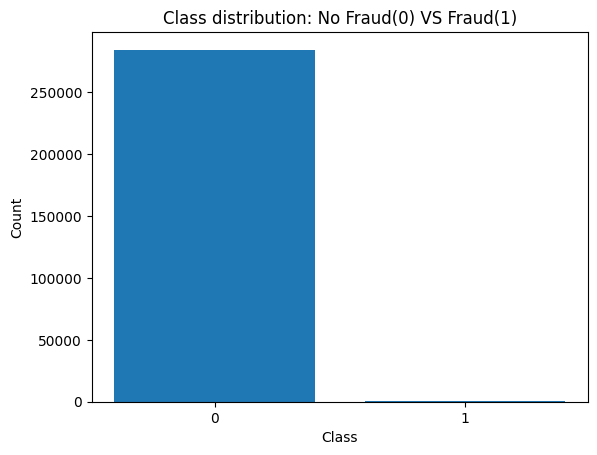

In [15]:
# Collect data for histogram
card_rdd = card_df.rdd
class_counts = card_rdd.map(lambda x: (x[-2], 1)).reduceByKey(lambda a, b: a + b).collect()
# Separate class names and counts
classes, counts = zip(*class_counts)

# Calculate the percentage of each class
total_samples = card_df.count()

for i in range(len(classes)):
    percentage = (counts[i] / total_samples) * 100
    print(f"Class {classes[i]}: {counts[i]} + {percentage:.2f}%")

# Plot the histogram
plt.bar(classes, counts)
plt.xticks([0, 1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class distribution: No Fraud(0) VS Fraud(1)')
plt.show()

## Oversampling

We can use different methods to deal with imbalanced data, for example, oversampling, undersampling, and SMOTE.

Oversampling duplicates samples from the minority class(fraud).

If I do oversampling first and then split it into train and test. In this way, the model will see a lot of test data in training as well. In order to avoid this leakage. I will first separate out the test dataset and do oversampling only in the training dataset.

In [16]:
major_train = train.filter(train["Class"] == 0)
minor_train = train.filter(train["Class"] == 1)
train_ratio = int(major_train.count() / minor_train.count())
print("Ratio: ", train_ratio)

Ratio:  586


In [17]:
from pyspark.sql.functions import lit

def oversampling(ratio):
    a = range(ratio)

    # Oversampling the minority class
    oversampled_df = minor_train.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

    # combine both oversampled minority rows and previous majority rows
    train_balanced = major_train.unionAll(oversampled_df)

    return train_balanced


def tuning_with_sampling(f):
    ratios = [2,3,5,10,25] # Ratio = count(majority_class)/count(minority_class)
    f1_scores = []
    max_f1 = 0
    best_r = None
    for r in ratios:
      train_balanced = f(r)
      f1 = predict_model(train_balanced, test)
      f1_scores.append(f1)

      if f1 > max_f1:
        max_f1 = f1
        best_r = r

    # Find the maximum F1 score and corresponding ratio
    print("Corresponding Ratio:", best_r)
    best_train_balanced = f(best_r)
    best_f1 = tuning(best_train_balanced, test)
    print("Prediction summary with best_r: ", best_f1)

if __name__ == "__main__":
    tuning_with_sampling(oversampling)

13 40
Prediction summary
Accuracy:  0.9993512375449849 Precision:  0.8888888888888888 Recall:  0.7222222222222222 F1:  0.7969348659003831


17 40
Prediction summary
Accuracy:  0.9993022743408329 Precision:  0.859504132231405 Recall:  0.7222222222222222 F1:  0.7849056603773585


16 36
Prediction summary
Accuracy:  0.999363478346023 Precision:  0.8709677419354839 Recall:  0.75 F1:  0.8059701492537312


16 37
Prediction summary
Accuracy:  0.9993512375449849 Precision:  0.8699186991869918 Recall:  0.7430555555555556 F1:  0.8014981273408239


27 27
Prediction summary
Accuracy:  0.9993389967439469 Precision:  0.8125 Recall:  0.8125 F1:  0.8125
Corresponding Ratio: 25


24/03/27 11:53:47 WARN DAGScheduler: Broadcasting large task binary with size 1062.7 KiB
24/03/27 11:53:48 WARN DAGScheduler: Broadcasting large task binary with size 1134.3 KiB
24/03/27 11:54:00 WARN DAGScheduler: Broadcasting large task binary with size 1053.8 KiB
24/03/27 11:54:01 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB
24/03/27 11:54:01 WARN DAGScheduler: Broadcasting large task binary with size 1363.4 KiB
24/03/27 11:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1487.9 KiB
24/03/27 11:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1587.6 KiB
24/03/27 11:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1126.5 KiB
24/03/27 11:54:31 WARN DAGScheduler: Broadcasting large task binary with size 1049.1 KiB
24/03/27 11:54:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.7 KiB
24/03/27 11:54:44 WARN DAGScheduler: Broadcasting large task binary with size 1075.9 KiB
24/03/27 11:54:45 WAR

3 35
Prediction summary
Accuracy:  0.9995348495605553 Precision:  0.9732142857142857 Recall:  0.7569444444444444 F1:  0.8515624999999999
Prediction summary with best_r:  0.8515624999999999


In [18]:
def undersampling(ratio):
    sampled_majority_train = major_train.sample(False, 1/ratio)
    train_balanced = sampled_majority_train.unionAll(minor_train)
    return train_balanced


if __name__ == "__main__":
    tuning_with_sampling(undersampling)


14 39
Prediction summary
Accuracy:  0.9993512375449849 Precision:  0.8823529411764706 Recall:  0.7291666666666666 F1:  0.7984790874524715


13 39
Prediction summary
Accuracy:  0.999363478346023 Precision:  0.8898305084745762 Recall:  0.7291666666666666 F1:  0.8015267175572519


14 37
Prediction summary
Accuracy:  0.999375719147061 Precision:  0.8842975206611571 Recall:  0.7430555555555556 F1:  0.8075471698113208


19 36
Prediction summary
Accuracy:  0.9993267559429089 Precision:  0.8503937007874016 Recall:  0.75 F1:  0.7970479704797048


39 25
Prediction summary
Accuracy:  0.9992165887335668 Precision:  0.7531645569620253 Recall:  0.8263888888888888 F1:  0.7880794701986755
Corresponding Ratio: 5


11 33
Prediction summary
Accuracy:  0.9994614047543271 Precision:  0.9098360655737705 Recall:  0.7708333333333334 F1:  0.8345864661654135
Prediction summary with best_r:  0.8345864661654135



By using a variety of oversampling and undersampling rates, when the oversampling or undersampling rate is close to 5, it increases the F1 score by roughly 2%. This helps increase the recall score a bit, but still does not do a good job.


## Combine oversampling with undersampling


In [19]:
def combined_sampling(ratio):
    # Oversampling the minority class
    a = range(ratio)
    oversampled_df = minor_train.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

    # Undersampling the majority class
    sampled_majority_train = major_train.sample(False, 1/ratio)

    # Combine oversampled minority rows and undersampled majority rows
    train_balanced = sampled_majority_train.unionAll(oversampled_df).unionAll(minor_train)

    return train_balanced

if __name__ == "__main__":
    tuning_with_sampling(combined_sampling)

18 36
Prediction summary
Accuracy:  0.9993389967439469 Precision:  0.8571428571428571 Recall:  0.75 F1:  0.7999999999999999


17 36
Prediction summary
Accuracy:  0.9993512375449849 Precision:  0.864 Recall:  0.75 F1:  0.8029739776951673


26 32
Prediction summary
Accuracy:  0.9992900335397948 Precision:  0.8115942028985508 Recall:  0.7777777777777778 F1:  0.7943262411347518


43 26
Prediction summary
Accuracy:  0.9991553847283766 Precision:  0.7329192546583851 Recall:  0.8194444444444444 F1:  0.7737704918032786


81049 122
Prediction summary
Accuracy:  0.006401938942884423 Precision:  0.0002713670733061144 Recall:  0.1527777777777778 F1:  0.0005417718401773072
Corresponding Ratio: 3


24/03/27 12:05:37 WARN DAGScheduler: Broadcasting large task binary with size 1035.1 KiB
24/03/27 12:05:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.5 KiB
24/03/27 12:05:44 WARN DAGScheduler: Broadcasting large task binary with size 1008.7 KiB
24/03/27 12:05:49 WARN DAGScheduler: Broadcasting large task binary with size 1008.7 KiB
24/03/27 12:05:49 WARN DAGScheduler: Broadcasting large task binary with size 1136.0 KiB
24/03/27 12:05:49 WARN DAGScheduler: Broadcasting large task binary with size 1246.2 KiB
24/03/27 12:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1336.1 KiB
24/03/27 12:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1405.7 KiB
24/03/27 12:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1457.8 KiB
24/03/27 12:05:51 WARN DAGScheduler: Broadcasting large task binary with size 1060.1 KiB
24/03/27 12:06:14 WARN DAGScheduler: Broadcasting large task binary with size 1011.8 KiB
24/03/27 12:06:15 WAR

13 36
Prediction summary
Accuracy:  0.999400200749137 Precision:  0.8925619834710744 Recall:  0.75 F1:  0.8150943396226414
Prediction summary with best_r:  0.8150943396226414


SMOTE [1] over-samples the minority class by generating synthetic minority examples in the neighborhood of observed ones. The idea
is to form new minority examples by interpolating between examples of the
same class. This has the effect of creating clusters around each minority
observation. For this project, I could not find anything implemented for SMOTE using pySpark, so I just use Pandas.

### SMOTE

In [21]:
from imblearn.over_sampling import SMOTE
pandas_df = train.toPandas()

# Step 3: Use SMOTE for resampling
X = pandas_df.drop("Class", axis=1)  # Features
y = pandas_df["Class"]  # Target variable

def smote(ratio):
    smote = SMOTE(sampling_strategy=1/ratio)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    resampled_df["Class"] = y_resampled

    # Create a PySpark DataFrame from the Pandas DataFrame
    balanced_train = spark.createDataFrame(resampled_df)

    return balanced_train

if __name__ == "__main__":
    tuning_with_sampling(smote)

24/03/27 13:11:33 WARN TaskSetManager: Stage 6856 contains a task of very large size (9585 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:11:36 WARN TaskSetManager: Stage 6859 contains a task of very large size (9585 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:11:40 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6859 (TID 85048): Attempting to kill Python Worker
24/03/27 13:11:40 WARN TaskSetManager: Stage 6860 contains a task of very large size (9585 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:11:42 WARN TaskSetManager: Stage 6861 contains a task of very large size (9585 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:11:43 WARN TaskSetManager: Stage 6863 contains a task of very large size (9585 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:11:45 WARN TaskSetManager: Stage 6865 contains a task of very large size (9585 KiB). The maximum recommended task size is 1000 

152 24
Prediction summary
Accuracy:  0.9978456190173085 Precision:  0.4411764705882353 Recall:  0.8333333333333334 F1:  0.576923076923077


24/03/27 13:12:27 WARN TaskSetManager: Stage 6929 contains a task of very large size (8521 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:12:28 WARN TaskSetManager: Stage 6932 contains a task of very large size (8521 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:12:33 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6932 (TID 85298): Attempting to kill Python Worker
24/03/27 13:12:33 WARN TaskSetManager: Stage 6933 contains a task of very large size (8521 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:12:33 WARN TaskSetManager: Stage 6934 contains a task of very large size (8521 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:12:35 WARN TaskSetManager: Stage 6936 contains a task of very large size (8521 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:12:36 WARN TaskSetManager: Stage 6938 contains a task of very large size (8521 KiB). The maximum recommended task size is 1000 

66 26
Prediction summary
Accuracy:  0.9988738463045022 Precision:  0.6413043478260869 Recall:  0.8194444444444444 F1:  0.7195121951219512


24/03/27 13:13:15 WARN TaskSetManager: Stage 7002 contains a task of very large size (7723 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:13:16 WARN TaskSetManager: Stage 7005 contains a task of very large size (7723 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:13:20 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 7005 (TID 85548): Attempting to kill Python Worker
24/03/27 13:13:20 WARN TaskSetManager: Stage 7006 contains a task of very large size (7723 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:13:21 WARN TaskSetManager: Stage 7007 contains a task of very large size (7723 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:13:22 WARN TaskSetManager: Stage 7009 contains a task of very large size (7723 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:13:23 WARN TaskSetManager: Stage 7011 contains a task of very large size (7723 KiB). The maximum recommended task size is 1000 

39 27
Prediction summary
Accuracy:  0.9991921071314906 Precision:  0.75 Recall:  0.8125 F1:  0.78


24/03/27 13:14:00 WARN TaskSetManager: Stage 7075 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:14:02 WARN TaskSetManager: Stage 7078 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:14:06 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 7078 (TID 85798): Attempting to kill Python Worker
24/03/27 13:14:06 WARN TaskSetManager: Stage 7079 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:14:06 WARN TaskSetManager: Stage 7080 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:14:07 WARN TaskSetManager: Stage 7082 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:14:09 WARN TaskSetManager: Stage 7084 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 

22 28
Prediction summary
Accuracy:  0.999387959948099 Precision:  0.8405797101449275 Recall:  0.8055555555555556 F1:  0.8226950354609929


24/03/27 13:14:45 WARN TaskSetManager: Stage 7148 contains a task of very large size (6658 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:14:46 WARN TaskSetManager: Stage 7151 contains a task of very large size (6658 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:14:50 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 7151 (TID 86048): Attempting to kill Python Worker
24/03/27 13:14:50 WARN TaskSetManager: Stage 7152 contains a task of very large size (6658 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:14:51 WARN TaskSetManager: Stage 7153 contains a task of very large size (6659 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:14:52 WARN TaskSetManager: Stage 7155 contains a task of very large size (6658 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:14:53 WARN TaskSetManager: Stage 7157 contains a task of very large size (6658 KiB). The maximum recommended task size is 1000 

26 33
Prediction summary
Accuracy:  0.9992777927387568 Precision:  0.8102189781021898 Recall:  0.7708333333333334 F1:  0.7900355871886121
Corresponding Ratio: 10


24/03/27 13:15:31 WARN TaskSetManager: Stage 7221 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:15:33 WARN TaskSetManager: Stage 7222 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:15:35 WARN TaskSetManager: Stage 7225 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:15:35 WARN TaskSetManager: Stage 7226 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:15:36 WARN TaskSetManager: Stage 7227 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:15:37 WARN TaskSetManager: Stage 7229 contains a task of very large size (6925 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 13:15:38 WARN TaskSetManager: Stage 7231 contains a task of very large size (6925 KiB). The maximum recommended task size is 10

11 35
Prediction summary
Accuracy:  0.9994369231522511 Precision:  0.9083333333333333 Recall:  0.7569444444444444 F1:  0.8257575757575757
Prediction summary with best_r:  0.8257575757575757


24/03/27 15:14:30 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1048236 ms exceeds timeout 120000 ms
24/03/27 15:14:30 WARN SparkContext: Killing executors is not supported by current scheduler.
24/03/27 15:14:31 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 

# References


* https://spark.apache.org/docs/2.1.0/ml-tuning.html
* https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253
* https://medium.com/@ravi.abhinav4/improving-class-imbalance-with-class-weights-in-machine-learning-af072fdd4aa4#:~:text=Using%20Class%20Weights%20to%20Address%20Class%20Imbalance,-Class%20weights%20offer&text=The%20idea%20is%20to%20assign,make%20better%20predictions%20for%20it.

[1] N. Chawla, K. Bowyer, L. Hall, W. Kegelmeyer, Smote: synthetic minority over-sampling technique, Arxiv preprint arXiv:1106.1813 (2011).\
[2] X. Liu, J. Wu, Z. Zhou, Exploratory undersampling for class-imbalance
learning, Systems, Man, and Cybernetics, Part B: Cybernetics, IEEE
Transactions on 39 (2009) 539–550.
